# Introduction

Notebook goals:

* Identify C.O.M of Fw regions and anchors
* Investigate movement between these points
* investigate changes in angles

In [1]:
import os
import itertools
import glob
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.aligners import align_pandas_structure, align_sequences
from python_pdb.parsers import parse_pdb_to_pandas
from python_pdb.entities import Structure
from python_pdb.comparisons import rmsd
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from tcr_structure_tools.cdr_numbering import assign_cdr_number

In [2]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned'

# Computing Measurements

In [3]:
def align_tcrs(tcr_mobile_df, tcr_target_df):            
    mobile_coords = []
    target_coords = []
        
    for chain_type in ('alpha_chain', 'beta_chain'):
        fw_chain_sequences = []
        fw_chain_ca_coords = []
        
        for df in (tcr_mobile_df, tcr_target_df):
            fw_chain = df.query('cdr.isnull() and residue_seq_id <= 128 and chain_type == @chain_type')
            
            fw_chain_ca_coords.append(fw_chain.query("atom_name == 'CA'")[['pos_x', 'pos_y', 'pos_z']].values)
            
            fw_chain_seq = fw_chain.drop_duplicates(['residue_seq_id', 'residue_insert_code'])['residue_name'].map(lambda tlc: THREE_TO_ONE_CODE[tlc]).tolist()
            fw_chain_sequences.append(fw_chain_seq)
        
        fw_chain_seq_alignment, _ = align_sequences(*fw_chain_sequences)
        

        iter_mobile_ca_coords = iter(fw_chain_ca_coords[0])
        iter_target_ca_coords = iter(fw_chain_ca_coords[1])

        for res_id_mobile, res_id_target in fw_chain_seq_alignment:
            next_res_ca_coords_mobile = next(iter_mobile_ca_coords) if res_id_mobile != '-' else None
            next_res_ca_coords_target = next(iter_target_ca_coords) if res_id_target != '-' else None

            if next_res_ca_coords_mobile is not None and next_res_ca_coords_target is not None:
                mobile_coords.append(next_res_ca_coords_mobile)
                target_coords.append(next_res_ca_coords_target)

    mobile_coords = np.array(mobile_coords)
    target_coords = np.array(target_coords)

    return align_pandas_structure(mobile_coords, target_coords, tcr_mobile_df)

In [4]:
def get_chain_assignments(file_path):
    chains = file_path.split('/')[-1].split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

def get_distance(vec1, vec2):
    '''Compute 3D euclidean distance between two vectors.'''
    xx = np.square(vec1[0] - vec2[0])
    yy = np.square(vec1[1] - vec2[1])
    zz = np.square(vec1[2] - vec2[2])
    
    return np.sqrt(xx + yy + zz)

def calculate_angle(vec1, vec2):
    '''Caculate the angle between two vectors.'''
    return np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))

In [5]:
def find_anchors(cdr_df, structure_df):
    cdr_start = cdr_df.iloc[0].name
    cdr_end = cdr_df.iloc[-1].name

    start_anchor_info = structure_df.loc[:cdr_start].tail(2).iloc[0][['chain_id', 'residue_seq_id', 'residue_insert_code']]
    end_anchor_info = structure_df.loc[cdr_end:].head(2).iloc[1][['chain_id', 'residue_seq_id', 'residue_insert_code']]

    if start_anchor_info['residue_insert_code']:
        start_anchor = structure_df.query(('chain_id == @start_anchor_info.chain_id'
                                           ' and residue_seq_id == @start_anchor_info.residue_seq_id'
                                           ' and residue_insert_code == @start_anchor_info.residue_insert_code'))

    else:
        start_anchor = structure_df.query(('chain_id == @start_anchor_info.chain_id'
                                           ' and residue_seq_id == @start_anchor_info.residue_seq_id'
                                           ' and residue_insert_code.isnull()'))

    if end_anchor_info['residue_insert_code']:
        end_anchor = structure_df.query(('chain_id == @end_anchor_info.chain_id'
                                         ' and residue_seq_id == @end_anchor_info.residue_seq_id'
                                         ' and residue_insert_code == @end_anchor_info.residue_insert_code'))

    else:
        end_anchor = structure_df.query(('chain_id == @end_anchor_info.chain_id'
                                         ' and residue_seq_id == @end_anchor_info.residue_seq_id'
                                         ' and residue_insert_code.isnull()'))
    
    return start_anchor, end_anchor

In [6]:
groups = []
apo_paths = []
holo_paths = []

alpha_anchor_com_diffs = []
beta_anchor_com_diffs = []

alpha_fw_com_diffs = []
beta_fw_com_diffs = []

chain_angle_diffs = []

for group in (dir_ for dir_ in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, dir_))):
    print(group)
    
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        state1 = path1.split('.')[0].split('_')[-1]
        state2 = path2.split('.')[0].split('_')[-1]

        # Skip holo-holo and apo-apo comparisons for now
        if state1 == state2:
            continue

        if state1 == 'apo':
            apo_path = path1
            holo_path = path2
        else:
            apo_path = path2
            holo_path = path1
        
        chains_apo = get_chain_assignments(apo_path)
        chains_holo = get_chain_assignments(holo_path)
        
        # Load Structures
        with open(os.path.join(DATA_DIR, group, apo_path), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        with open(os.path.join(DATA_DIR, group, holo_path), 'r') as fh:
            holo_df = parse_pdb_to_pandas(fh.read())
        
        # Annotate records
        apo_df['chain_type'] = apo_df['chain_id'].map(chains_apo)
        holo_df['chain_type'] = holo_df['chain_id'].map(chains_holo)
        
        apo_df['cdr'] = apo_df['residue_seq_id'].map(assign_cdr_number)
        holo_df['cdr'] = holo_df['residue_seq_id'].map(assign_cdr_number)
        
        apo_tcr_df = apo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        holo_tcr_df = holo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        
        apo_tcr_df = align_tcrs(apo_tcr_df, holo_tcr_df)
        
        # Compute C.O.Ms and coordinate vectors
        calculations = defaultdict(dict)
        
        for label, tcr_df in (('apo', apo_tcr_df), ('holo', holo_tcr_df)):
            for chain_type in ('alpha_chain', 'beta_chain'):
                anchors_ca = pd.DataFrame()

                for cdr in (1, 2, 3):
                    cdr_df = tcr_df.query('chain_type == @chain_type and cdr == @cdr')

                    for cdr_anchor in find_anchors(cdr_df, tcr_df):
                        anchors_ca = pd.concat([anchors_ca, cdr_anchor.query("atom_name == 'CA'")])

                fw_ca_df = tcr_df.query("cdr.isnull() and residue_seq_id <= 128 and chain_type == @chain_type and atom_name == 'CA'")

                anchors_com = np.average(get_coords(anchors_ca), axis=0)
                fw_com = np.average(get_coords(fw_ca_df), axis=0)

                tcr_chain_direction_vec = fw_com - anchors_com
                
                calculations[label][chain_type] = {}
                
                calculations[label][chain_type]['anchors_com'] = anchors_com
                calculations[label][chain_type]['fw_com'] = fw_com
                calculations[label][chain_type]['direction_vector'] = tcr_chain_direction_vec
                
        
        # Calculate differences
        chain_anchor_com = []
        chain_fw_com = []
        for chain_type in ('alpha_chain', 'beta_chain'):
            chain_anchor_com.append(get_distance(calculations['apo'][chain_type]['anchors_com'],
                                                 calculations['holo'][chain_type]['anchors_com']))
            
            chain_fw_com.append(get_distance(calculations['apo'][chain_type]['fw_com'],
                                             calculations['holo'][chain_type]['fw_com']))
            
            
        angle_apo = calculate_angle(calculations['apo']['alpha_chain']['direction_vector'],
                                    calculations['apo']['beta_chain']['direction_vector'])
        
        angle_holo = calculate_angle(calculations['holo']['alpha_chain']['direction_vector'],
                                     calculations['holo']['beta_chain']['direction_vector'])
        
        angle_diff = angle_holo - angle_apo
        
        # Collect Data
        groups.append(group)
        apo_paths.append(apo_path)
        holo_paths.append(holo_path)

        alpha_anchor_com_diffs.append(chain_anchor_com[0])
        beta_anchor_com_diffs.append(chain_anchor_com[1])

        alpha_fw_com_diffs.append(chain_fw_com[0])
        beta_fw_com_diffs.append(chain_fw_com[1])

        chain_angle_diffs.append(angle_diff)

results = pd.DataFrame({
    'group': groups,
    'apo_path': apo_paths,
    'holo_path': holo_paths,
    'alpha_anchor_com_diff': alpha_anchor_com_diffs,
    'beta_anchor_com_diff': beta_anchor_com_diffs,
    'alpha_fw_com_diff': alpha_fw_com_diffs,
    'beta_fw_com_diff': beta_fw_com_diffs, 
    'chain_angle_diff': chain_angle_diffs,
})

YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGAGGADTQY
7n1c_DE_apo.pdb 7n1e_DECA_holo.pdb
NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQRQEGDTQY
6at6_AB_apo.pdb 6avf_ABPH_holo.pdb
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY
3vxt_AB_apo.pdb 3vxu_DECA_holo.pdb
3vxt_AB_apo.pdb 3w0w_DECA_holo.pdb
3vxu_DECA_holo.pdb 3w0w_DECA_holo.pdb
NSASQS-VYSSG-VVQPGGYQKVT-MNHNS-SASEGT-ASSEGLWQVGDEQY
6vth_DE_apo.pdb 6vrm_DEPA_holo.pdb
YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY
1g6r_ABPH_holo.pdb 2ckb_CDQI_holo.pdb
1g6r_ABPH_holo.pdb 1mwa_ABPH_holo.pdb
1g6r_ABPH_holo.pdb 2oi9_BCQA_holo.pdb
1g6r_ABPH_holo.pdb 1tcr_AB_apo.pdb
2ckb_CDQI_holo.pdb 1mwa_ABPH_holo.pdb
2ckb_CDQI_holo.pdb 2oi9_BCQA_holo.pdb
2ckb_CDQI_holo.pdb 1tcr_AB_apo.pdb
1mwa_ABPH_holo.pdb 2oi9_BCQA_holo.pdb
1mwa_ABPH_holo.pdb 1tcr_AB_apo.pdb
2oi9_BCQA_holo.pdb 1tcr_AB_apo.pdb
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY
5nmf_DECA_holo.pdb 5nmd_AB_apo.pdb
5nmf_DECA_holo.pdb 5nmg_DECA_holo.pdb
5nmf_DECA_holo.pdb 5nme_IJHF_holo.p

In [7]:
results

,group,apo_path,holo_path,alpha_anchor_com_diff,beta_anchor_com_diff,alpha_fw_com_diff,beta_fw_com_diff,chain_angle_diff
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,0.720242,0.455556,0.041055,0.039686,0.112181
1,NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQR...,6at6_AB_apo.pdb,6avf_ABPH_holo.pdb,0.518325,0.304673,0.347432,0.483417,0.023791
2,DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY,3vxt_AB_apo.pdb,3vxu_DECA_holo.pdb,0.712083,0.190105,0.110174,0.105331,0.072246
3,DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY,3vxt_AB_apo.pdb,3w0w_DECA_holo.pdb,1.469496,0.545301,0.294271,0.200982,0.125650
4,NSASQS-VYSSG-VVQPGGYQKVT-MNHNS-SASEGT-ASSEGLWQ...,6vth_DE_apo.pdb,6vrm_DEPA_holo.pdb,0.190596,0.344597,0.214515,0.304252,-0.007848
5,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,1tcr_AB_apo.pdb,1g6r_ABPH_holo.pdb,0.310632,0.393574,0.021478,0.020534,-0.037857
6,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,1tcr_AB_apo.pdb,2ckb_CDQI_holo.pdb,0.292102,0.602167,0.149429,0.142861,-0.091281
7,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,1tcr_AB_apo.pdb,1mwa_ABPH_holo.pdb,0.288958,0.483175,0.023885,0.022835,-0.052079
8,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,1tcr_AB_apo.pdb,2oi9_BCQA_holo.pdb,0.630315,0.562047,0.377876,0.176233,-0.082930
9,DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVS...,5nmd_AB_apo.pdb,5nmf_DECA_holo.pdb,0.444867,0.412156,0.116530,0.205030,0.024253


In [8]:
results_norm = results.groupby(['group']).agg({'alpha_anchor_com_diff': 'mean',
                                               'beta_anchor_com_diff': 'mean',
                                               'alpha_fw_com_diff': 'mean',
                                               'beta_fw_com_diff': 'mean',
                                               'chain_angle_diff': 'mean'})

In [9]:
results_norm['chain_angle_diff_deg'] = results_norm['chain_angle_diff'].apply(np.degrees)
results_norm['chain_angle_diff_deg_mag'] = results_norm['chain_angle_diff_deg'].apply(np.abs)

In [10]:
results_norm

,alpha_anchor_com_diff,beta_anchor_com_diff,alpha_fw_com_diff,beta_fw_com_diff,chain_angle_diff,chain_angle_diff_deg,chain_angle_diff_deg_mag
group,,,,,,,
DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,0.537963,0.272047,0.190109,0.128358,0.041688,2.388572,2.388572
DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,0.422340,0.332782,0.317172,0.193225,-0.011922,-0.683052,0.683052
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY,0.462851,0.553689,0.136174,0.161396,0.021052,1.206219,1.206219
DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLAGGRPEQY,0.270855,0.371669,0.290980,0.346284,-0.012562,-0.719769,0.719769
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY,1.090790,0.367703,0.202223,0.153156,0.098948,5.669283,5.669283
DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGTGINYGYT,0.606291,0.022299,0.179704,0.185719,-0.037514,-2.149375,2.149375
DSAIYN-IQSSQRE-AVRMDSSYKLI-SEHNR-FQNEAQ-ASSSWDTGELF,0.349653,0.324879,0.124697,0.120586,-0.025890,-1.483382,1.483382
DSAIYN-IQSSQRE-AVRPLLDGTYIPT-MNHEY-SVGAGT-ASSYLGNTGELF,0.332554,0.493014,0.475309,0.500443,-0.044680,-2.559998,2.559998
DSAIYN-IQSSQRE-AVRPTSGGSYIPT-MNHEY-SVGAGI-ASSYVGNTGELF,0.479149,0.446931,0.358840,0.346023,-0.030080,-1.723431,1.723431


# Visualizing Results

## Changes in angle between alpha and beta chain

count    18.000000
mean     -0.002660
std       0.058163
min      -0.133267
25%      -0.035655
50%      -0.009885
75%       0.025981
max       0.112181
Name: chain_angle_diff, dtype: float64

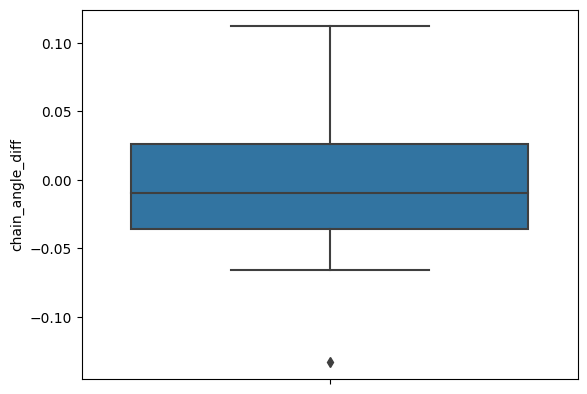

In [11]:
sns.boxplot(results_norm, y='chain_angle_diff')
results_norm['chain_angle_diff'].describe()

count    18.000000
mean     -0.152421
std       3.332473
min      -7.635633
25%      -2.042889
50%      -0.566345
75%       1.488629
max       6.427524
Name: chain_angle_diff_deg, dtype: float64

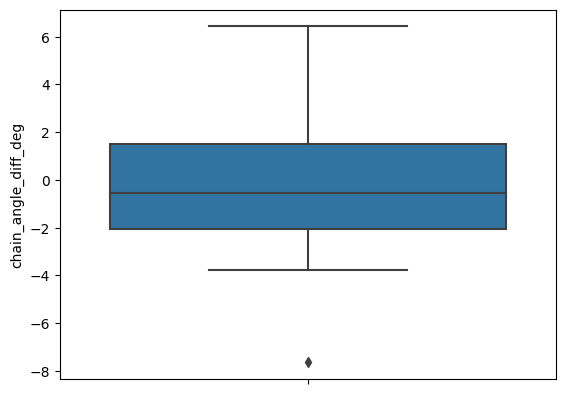

In [12]:
sns.boxplot(results_norm, y='chain_angle_diff_deg')
results_norm['chain_angle_diff_deg'].describe()

count    18.000000
mean      2.514822
std       2.105617
min       0.160906
25%       1.245450
50%       1.936403
75%       2.671406
max       7.635633
Name: chain_angle_diff_deg_mag, dtype: float64

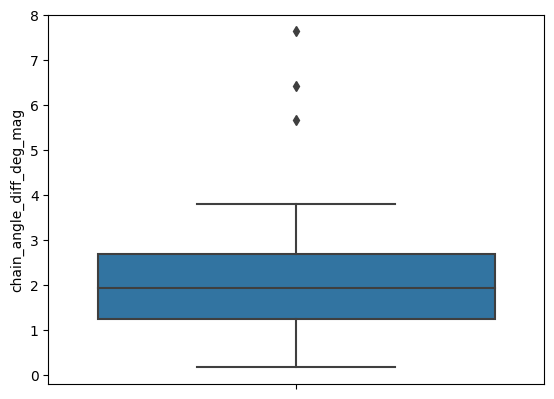

In [13]:
sns.boxplot(results_norm, y='chain_angle_diff_deg_mag')
results_norm['chain_angle_diff_deg_mag'].describe()

From these plots, it does not seem that their is alot of angular change between domains.

## Changes in Framework (Fw) region and Loop Anchor Centre of Masses (COM)

In [14]:
coms = results_norm.melt(value_vars=['alpha_anchor_com_diff', 'beta_anchor_com_diff', 'alpha_fw_com_diff', 'beta_fw_com_diff'],
                         var_name='location',
                         value_name='com_diff')

coms['chain_type'] = coms['location'].map(lambda location: location.split('_')[0])
coms['location'] = coms['location'].map(lambda location: location.split('_')[1])

<Axes: xlabel='location', ylabel='com_diff'>

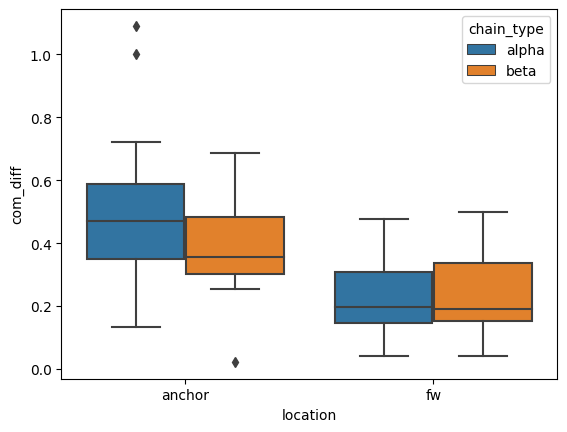

In [15]:
sns.boxplot(coms, y='com_diff', x='location', hue='chain_type')